In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization:** The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape:** The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [3]:
# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Build Generator

### This generator is part of a CGAN that generates images according to the given label.

### It combines random noise with a label to create a specific image class (e.g., generating a "2" when the label is 2).

In [4]:
# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()
build_generator().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 100)         │          1,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100)            │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 100)            │              0 │ input_layer_3[0][0],   │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 28, 28, 1)      │      1,493,520 │ multiply_1[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,494,520 (5.70 MB)

 Trainable params: 1,490,936 (5.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

# Build Discriminator Model

### This model is a discriminator in a CGAN. It takes both an image and a label as input and determines whether the image is real or fake, based on the given label.

### By combining the image and label inputs, the discriminator can ensure that the image corresponds to the specified label before deciding if it's real or fake.

In [5]:
# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

# Build the discriminator and print the summary
discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 784)         │          7,840 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 784)            │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 28, 28, 1)      │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 2)      │              0 │ input_layer_6[0][0],   │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 1)              │        934,913 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 942,753 (3.60 MB)

 Trainable params: 942,753 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

# Build and Compile the Models

### The **discriminator** is compiled with the Adam optimizer and binary cross-entropy loss since it needs to classify whether the input is real or fake (binary classification). The accuracy metric is also tracked.

### The **GAN** model is created by combining the generator and discriminator. It takes random noise and a label as input, generates an image, and then passes that image (along with the label) to the discriminator to check if it's real or fake.

### The GAN is also compiled with binary cross-entropy loss since it still involves distinguishing between real and fake images.

In [6]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the Function

### Two arrays, real and fake, are created to represent the target labels: 1 for real images and 0 for fake images.

### The loop runs for a specified number of epochs, where a random batch of real images and their corresponding labels is selected from the dataset for each iteration.

### **Random noise** is generated and fed into the generator (along with the labels) to create fake images.

### The **discriminator** is trained on both the real images (with label 1) and the generated (fake) images (with label 0). The final loss for the discriminator is the average of the two losses.

### The generator is trained through the GAN by trying to fool the discriminator into thinking the generated images are real. The target labels for this are 1 (real) because the generator is rewarded when it can make the discriminator believe its images are real.

In [7]:
# Training function for a specific digit with label smoothing
def train(epochs, batch_size=128, save_interval=200, digit=7):  # Add the 'digit' argument
    for epoch in range(epochs):
        # Filter training data for the specified digit
        idx_digit = np.where(Y_train == digit)[0]

        # Randomly select a batch of real images (only for the specified digit)
        idx = np.random.choice(idx_digit, batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        # Implement label smoothing for real images
        real_smoothed = np.random.uniform(0.9, 1, size=(batch_size, 1))

        # Fake labels (0)
        fake = np.zeros((batch_size, 1))

        # Train the discriminator with real images (smoothed labels) and fake images (0)
        d_loss_real = discriminator.train_on_batch([real_images, labels], real_smoothed)  # Smoothing real labels
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)  # Fake labels unchanged
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator to fool the discriminator (use real labels for the generator)
        g_loss = gan.train_on_batch([noise, labels], np.ones((batch_size, 1)))

        # Print progress and save generated images at intervals
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, digit=digit)




# Saving Generated Images

### This function generates and saves images at each specified interval. It generates 10 images (for digits 0-9) by feeding random noise and the corresponding labels into the generator.

### The images are rescaled from the range [-1, 1] to [0, 1] for display. A 2x5 grid of images is created and displayed.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6108098030090332, acc.: 0.0%] [G loss: [array(0.64231735, dtype=float32), array(0.64231735, dtype=float32), array(0., dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


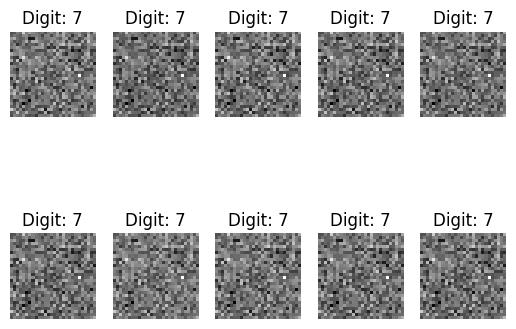

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━

In [8]:
# Function to save generated images for a specific digit
def save_images(epoch, digit=7):  # You can change 'digit' to 7 or 9 as needed
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.array([digit] * (r * c))  # Generate only the specified digit
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {digit}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the CGAN
train(epochs=100, batch_size=64, save_interval=100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


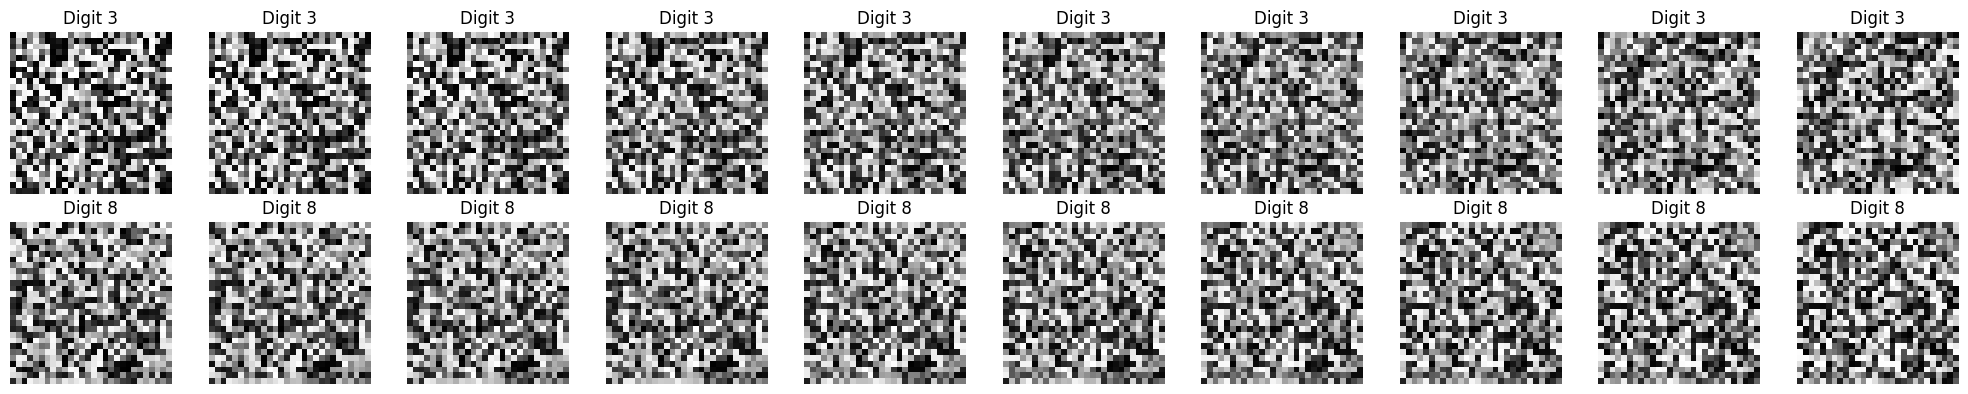

In [9]:
# Function to perform interpolation and visualize generated images morphing from one digit to another
def interpolate_between_digits(digit1, digit2, num_steps=10):
    # Generate random noise vectors for the two digits
    noise1 = np.random.normal(0, 1, (1, 100))  # Noise for digit1
    noise2 = np.random.normal(0, 1, (1, 100))  # Noise for digit2

    # Generate labels for the two digits
    label1 = np.array([digit1])
    label2 = np.array([digit2])

    # Create an array to store interpolated images
    interpolated_images = []

    # Interpolate between noise1 and noise2
    for alpha in np.linspace(0, 1, num_steps):
        interpolated_noise = (1 - alpha) * noise1 + alpha * noise2  # Linear interpolation
        interpolated_image1 = generator.predict([interpolated_noise, label1])
        interpolated_image2 = generator.predict([interpolated_noise, label2])

        # Append generated images to the list
        interpolated_images.append((interpolated_image1, interpolated_image2))

    # Rescale images from [-1, 1] to [0, 1]
    interpolated_images = [(0.5 * img1 + 0.5, 0.5 * img2 + 0.5) for img1, img2 in interpolated_images]

    # Plot the images
    fig, axs = plt.subplots(2, num_steps, figsize=(num_steps * 2, 4))

    for i, (img1, img2) in enumerate(interpolated_images):
        # Top row for digit1 morphing to digit2
        axs[0, i].imshow(img1[0, :, :, 0], cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Digit {digit1}")

        # Bottom row for digit2
        axs[1, i].imshow(img2[0, :, :, 0], cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title(f"Digit {digit2}")

    plt.tight_layout()
    plt.show()

# Perform interpolation between digits '3' and '8'
interpolate_between_digits(3, 8, num_steps=10)


# Question 01

## **Modify the CGAN to generate images for specific digits (e.g., generate only '7' or '9').**

---

# Question 02

## **Add label smoothing (e.g., replace real labels of 1 with random values between 0.9 and 1) during training. Analyze how label smoothing affects the training process and the quality of generated images.**

---

# Question 03

## **Generate noise vectors corresponding to two different digits (e.g., '3' and '8'). Perform interpolation between the two noise vectors and visualize how the generated images morph from one digit to the other.**

